## Evaluations - Generation (First Response)

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

from time import sleep

# Load evaluation/evaluation.csv as df
import pandas as pd
scenarios = pd.read_csv(os.path.join("evaluation", "scenarios_annotated.csv"))
scenarios = scenarios[scenarios['set'].isin(['generic_1','specific_1'])]

import requests

# for each row in df...
for index, row in scenarios.iterrows():

    print(f"Processing scenario {index + 1} of {len(scenarios)}: {row['user_prompt']}")
    print(f"Degree Program: {row['degree_major_concentration']}, Catalog Year: {row['catalog_year']}, Credits Earned: {row['credit_hours']}")

    conversation_history = []
    conversation_history.append({
        "role": "assistant",
        "content": "Hello! How can I assist you today?"
        })    

    
    attempts = 0
    while attempts < 5:
        
        attempts += 1
        prompt_response = requests.post(
            "http://host.docker.internal:8001/process-prompt",
            json={
                "conversation_history": conversation_history,
                "user_prompt_text": row['user_prompt'],
                "student_degree_program": row['degree_major_concentration'],
                "student_catalog_year": row['catalog_year'],
                "student_credits_earned": row['credit_hours'],
            })

        print (f"Response status code: {prompt_response.status_code}")
        status_code = prompt_response.status_code
        if status_code == 200:
            break
        else:
            sleep(10)
            

    response_data = prompt_response.json()



    # Record information into df - FIXED: Update DataFrame directly using .loc
    scenarios.loc[index, 'generated_response'] = response_data['generated_response']
    
    scenarios.loc[index, 'planning_time'] = response_data['planning_time']
    scenarios.loc[index, 'retrieval_time'] = response_data['retrieval_time']
    scenarios.loc[index, 'generation_time'] = response_data['generation_time']
    scenarios.loc[index, 'planning_attempts'] = response_data['planning_attempts']
    scenarios.loc[index, 'analytical_summary'] = response_data['analytical_summary']
    scenarios.loc[index, 'information_requests'] = response_data['information_requests']
    
    sleep(4)


scenarios.head()

Processing scenario 1 of 59: Which courses should I prioritize for next semester to stay on track for graduation?
Degree Program: BSCPE Computer Engineering, Machine Learning Concentration, Catalog Year: 2023-2024, Credits Earned: Up to 29
Response status code: 200
Processing scenario 2 of 59: Are there any prerequisite chains I should be aware of that could delay my graduation?
Degree Program: BSME Mechanical Engineering, Catalog Year: 2024-2025, Credits Earned: Up to 29
Response status code: 200
Processing scenario 3 of 59: What's the recommended sequence for my remaining core ME courses?
Degree Program: BSEE Electrical Engineering, Power and Energy Systems Concentration, Catalog Year: 2021-2022, Credits Earned: 90 to 119
Response status code: 200
Processing scenario 4 of 59: Should I take any courses over the summer to lighten my regular semester load?
Degree Program: BS Environmental Engineering, Catalog Year: 2025-2026, Credits Earned: Up to 29
Response status code: 200
Processing

,index,set,topic,user_prompt,credit_hours,catalog_year,degree_major_concentration,should_retrieve_semantic_courses,should_retrieve_semantic_programs,should_request_semantic_support_resources,...,should_refer_to_class_schedule,should_refer_to_advisor,provide_generic_advice,generated_response,planning_time,retrieval_time,generation_time,planning_attempts,analytical_summary,information_requests
0,1,generic_1,Academic Planning & Course Selection,Which courses should I prioritize for next sem...,Up to 29,2023-2024,"BSCPE Computer Engineering, Machine Learning C...",0,0,0,...,1,1,?,Since you’re pursuing a B.S. in Computer Engin...,2.962876,1.766779,6.270182,1.0,The user is seeking guidance on selecting cour...,<Specific_Request_Current_Major> </Specific_Re...
1,2,generic_1,Academic Planning & Course Selection,Are there any prerequisite chains I should be ...,Up to 29,2024-2025,BSME Mechanical Engineering,0,0,0,...,?,1,?,"Yes, there are several prerequisite chains in ...",3.088963,0.649265,9.296111,1.0,The student is asking about prerequisite chain...,<Specific_Request_Current_Major> </Specific_R...
2,3,generic_1,Academic Planning & Course Selection,What's the recommended sequence for my remaini...,90 to 119,2021-2022,"BSEE Electrical Engineering, Power and Energy ...",0,0,0,...,0,1,?,Since you're a senior with 90-119 credit hours...,2.542450,0.802118,5.869546,1.0,The user is asking for the recommended course ...,<Specific_Request_Current_Major_Sample_Schedul...
3,4,generic_1,Academic Planning & Course Selection,Should I take any courses over the summer to l...,Up to 29,2025-2026,BS Environmental Engineering,0,0,0,...,1,?,?,Taking courses over the summer can be a great ...,2.668790,0.000280,5.226233,1.0,The user wants guidance on whether they should...,<Specific_Request_Current_Major_Sample_Schedul...
4,5,generic_1,Academic Planning & Course Selection,Which electives would best complement my caree...,Up to 29,2025-2026,BSME Mechanical Engineering,0,0,0,...,0,?,?,That’s a great question! The best electives fo...,1.768797,0.000376,7.176547,1.0,The user is asking for recommendations on elec...,<Specific_Request_Current_Major> </Specific_Re...


In [ ]:

# Start with batch expansions of dataframe for evaluations

# Find tag in information requests
scenarios['actually_requested_semantic_courses'] = scenarios['information_requests'].str.contains('<Semantic_Request_Courses>', na=False).astype(int)
scenarios['actually_requested_semantic_programs'] = scenarios['information_requests'].str.contains('<Semantic_Request_Programs>', na=False).astype(int)
scenarios['actually_requested_semantic_support_resources'] = scenarios['information_requests'].str.contains('<Semantic_Request_Support_Resources>', na=False).astype(int)
scenarios['actually_requested_current_major'] = scenarios['information_requests'].str.contains('<Specific_Request_Current_Major>', na=False).astype(int)
scenarios['actually_requested_current_major_sample_schedules'] = scenarios['information_requests'].str.contains('<Specific_Request_Current_Major_Sample_Schedules>', na=False).astype(int)

mapping = {
    '00': 'tn',  # true negative
    '01': 'fp',  # false positive
    '10': 'fn',  # false negative
    '11': 'tp',  # true positive
    '?0': 'opt-no',   # optional request was not made
    '?1': 'opt-yes'    # optional request was made
}

scenarios['errors_semantic_courses'] = scenarios['should_retrieve_semantic_courses'].astype(str) + scenarios['actually_requested_semantic_courses'].astype(str)
scenarios['errors_semantic_courses'] = scenarios['errors_semantic_courses'].replace(mapping)

scenarios['errors_semantic_programs'] = scenarios['should_retrieve_semantic_programs'].astype(str) + scenarios['actually_requested_semantic_programs'].astype(str)
scenarios['errors_semantic_programs'] = scenarios['errors_semantic_programs'].replace(mapping)

scenarios['errors_semantic_support_resources'] = scenarios['should_request_semantic_support_resources'].astype(str) + scenarios['actually_requested_semantic_support_resources'].astype(str)
scenarios['errors_semantic_support_resources'] = scenarios['errors_semantic_support_resources'].replace(mapping)

scenarios['errors_current_major'] = scenarios['should_retrieve_current_major'].astype(str) + scenarios['actually_requested_current_major'].astype(str)
scenarios['errors_current_major'] = scenarios['errors_current_major'].replace(mapping)

scenarios['errors_current_major_sample_schedules'] = scenarios['should_retrieve_current_major_sample_schedule'].astype(str) + scenarios['actually_requested_current_major_sample_schedules'].astype(str)
scenarios['errors_current_major_sample_schedules'] = scenarios['errors_current_major_sample_schedules'].replace(mapping)


scenarios.head()

,index,set,topic,user_prompt,credit_hours,catalog_year,degree_major_concentration,should_retrieve_semantic_courses,should_retrieve_semantic_programs,should_request_semantic_support_resources,...,actually_requested_semantic_courses,actually_requested_semantic_programs,actually_requested_semantic_support_resources,actually_requested_current_major,actually_requested_current_major_sample_schedules,errors_semantic_courses,errors_semantic_programs,errors_semantic_support_resources,errors_current_major,errors_current_major_sample_schedules
0,1,generic_1,Academic Planning & Course Selection,Which courses should I prioritize for next sem...,Up to 29,2023-2024,"BSCPE Computer Engineering, Machine Learning C...",0,0,0,...,1,0,0,1,1,fp,tn,tn,tp,tp
1,2,generic_1,Academic Planning & Course Selection,Are there any prerequisite chains I should be ...,Up to 29,2024-2025,BSME Mechanical Engineering,0,0,0,...,1,0,0,1,1,fp,tn,tn,tp,opt-yes
2,3,generic_1,Academic Planning & Course Selection,What's the recommended sequence for my remaini...,90 to 119,2021-2022,"BSEE Electrical Engineering, Power and Energy ...",0,0,0,...,1,0,0,0,1,fp,tn,tn,opt-no,tp
3,4,generic_1,Academic Planning & Course Selection,Should I take any courses over the summer to l...,Up to 29,2025-2026,BS Environmental Engineering,0,0,0,...,0,0,1,0,1,tn,tn,fp,fn,tp
4,5,generic_1,Academic Planning & Course Selection,Which electives would best complement my caree...,Up to 29,2025-2026,BSME Mechanical Engineering,0,0,0,...,0,0,1,1,0,tn,tn,fp,tp,opt-no


In [ ]:
# Save expanded scenarios to CSV
ISO_DATE = pd.Timestamp.now().strftime('%Y-%m-%d')

scenarios.to_csv(os.path.join(f"evaluation", "responses_expanded_{ISO_DATE}.csv"_), index=False)
print("Expanded scenarios saved to evaluation/responses_expanded.csv")

In [20]:
scenarios['errors_semantic_courses'].value_counts()

errors_semantic_courses
tn        44
tp         6
fp         4
opt-no     3
fn         2
Name: count, dtype: int64

In [21]:
scenarios['errors_semantic_programs'].value_counts()

errors_semantic_programs
tn         45
tp          5
fn          5
opt-no      2
fp          1
opt-yes     1
Name: count, dtype: int64

In [22]:
scenarios['errors_semantic_support_resources'].value_counts()

errors_semantic_support_resources
tp         30
fp         15
tn          9
opt-yes     2
fn          2
opt-no      1
Name: count, dtype: int64

In [23]:
scenarios['errors_current_major'].value_counts()

errors_current_major
tn        24
tp        14
opt-no    11
fn         7
fp         3
Name: count, dtype: int64

In [24]:
scenarios['errors_current_major_sample_schedules'].value_counts()

errors_current_major_sample_schedules
tn         36
tp         11
opt-no      6
opt-yes     4
fn          2
Name: count, dtype: int64

In [ ]:
# Save the updated DataFrame to a new CSV file
output_file_path = os.path.join("evaluation", "scenarios_annotated_with_responses_20250630_run2.csv")
scenarios.to_csv(output_file_path, index=False)

In [4]:
# Load run 1
import os
import pandas as pd
scenarios = pd.read_csv(os.path.join("evaluation", "scenarios_annotated_with_responses_20250630_run1.csv"))

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import pandas as pd
import numpy as np

def calculate_metrics(y_true, y_pred, title="Classification Results"):
    # Calculate confusion matrix components
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

    # Calculate key metrics
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Create confusion matrix table
    confusion_data = {
        'Metric': ['True Positives (TP)', 'False Positives (FP)', 'True Negatives (TN)', 'False Negatives (FN)'],
        'Count': [tp, fp, tn, fn]
    }
    confusion_df = pd.DataFrame(confusion_data)

    print(f"=== {title} ===\n")
    print("Confusion Matrix Components:")
    print(confusion_df.to_string(index=False))
    print()

    # Create metrics table
    metrics_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 'F1-Score', 'ROC-AUC'],
        'Value': [accuracy, precision, recall, specificity, f1, roc_auc],
        'Formula/Description': [
            '(TP + TN) / (TP + TN + FP + FN)',
            'TP / (TP + FP)',
            'TP / (TP + FN)',
            'TN / (TN + FP)',
            '2 * (Precision * Recall) / (Precision + Recall)',
            'Area Under ROC Curve'
        ]
    }
    metrics_df = pd.DataFrame(metrics_data)

    print("Performance Metrics:")
    print(metrics_df.to_string(index=False, float_format='%.4f'))
    print()

    # Display detailed classification report
    print("Detailed Classification Report:")
    print(metrics.classification_report(y_true, y_pred))
    print()

    # Create pretty confusion matrix visualization
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    # Create figure with single subplot
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
    
    # Plot: Confusion Matrix with counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Did Not Request', 'Did Request'],
                yticklabels=['Should Not Have Requested', 'Should Have Requested'],
                ax=ax1, cbar_kws={'label': 'Count'}, 
                annot_kws={'size': 24, 'weight': 'bold'})  # Even larger annotation text
    ax1.set_title(f'{title}', fontsize=24, fontweight='bold', pad=20)  # Much larger title, removed "Confusion Matrix - Counts"
    ax1.set_xlabel('Predicted Label', fontsize=18, fontweight='bold')  # Larger axis labels
    ax1.set_ylabel('Actual Label', fontsize=18, fontweight='bold')    # Larger axis labels
    
    # Make tick labels much larger
    ax1.tick_params(axis='both', which='major', labelsize=16)
    
    # Add custom annotations for clarity in corners (larger text)
    ax1.text(0.15, 0.15, 'TN', ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    ax1.text(1.85, 0.15, 'FP', ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    ax1.text(0.15, 1.85, 'FN', ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    ax1.text(1.85, 1.85, 'TP', ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Create a summary metrics visualization
    fig, ax = plt.subplots(figsize=(12, 7))
    
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'ROC-AUC']
    metrics_values = [accuracy, precision, recall, specificity, f1, roc_auc]
    
    # Create color map based on performance
    colors = ['lightcoral' if x < 0.7 else 'gold' if x < 0.85 else 'lightgreen' for x in metrics_values]
    
    bars = ax.bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars with larger font
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=14)
    
    ax.set_title(f'Performance Metrics Overview\n{title}', fontsize=16, fontweight='bold')
    ax.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3)
    
    # Add horizontal reference lines
    ax.axhline(y=0.7, color='red', linestyle='--', alpha=0.5, label='Poor (< 0.7)')
    ax.axhline(y=0.85, color='orange', linestyle='--', alpha=0.5, label='Good (0.7-0.85)')
    ax.legend(loc='upper right', fontsize=12)
    
    # Make tick labels larger
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return {
        'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp},
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1': f1,
            'roc_auc': roc_auc
        }
    }

=== Semantic Retrieval Request - Courses ===

Confusion Matrix Components:
              Metric  Count
 True Positives (TP)      6
False Positives (FP)      4
 True Negatives (TN)     44
False Negatives (FN)      2

Performance Metrics:
              Metric  Value                             Formula/Description
            Accuracy 0.8929                 (TP + TN) / (TP + TN + FP + FN)
           Precision 0.6000                                  TP / (TP + FP)
Recall (Sensitivity) 0.7500                                  TP / (TP + FN)
         Specificity 0.9167                                  TN / (TN + FP)
            F1-Score 0.6667 2 * (Precision * Recall) / (Precision + Recall)
             ROC-AUC 0.8333                            Area Under ROC Curve

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        48
           1       0.60      0.75      0.67         8

    accuracy                      

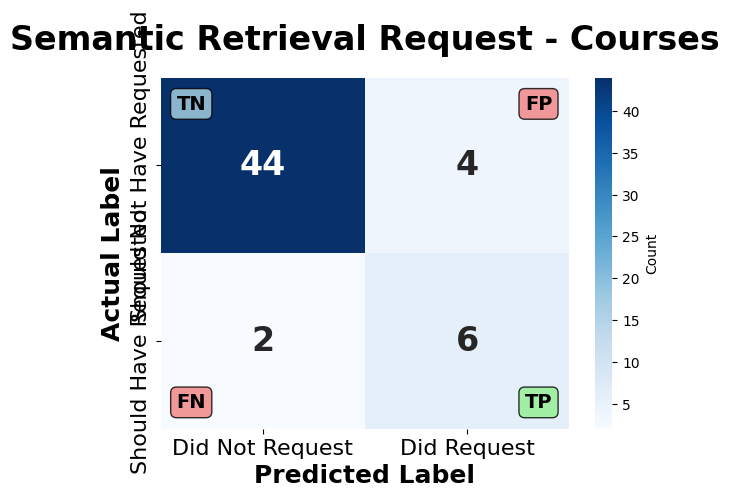

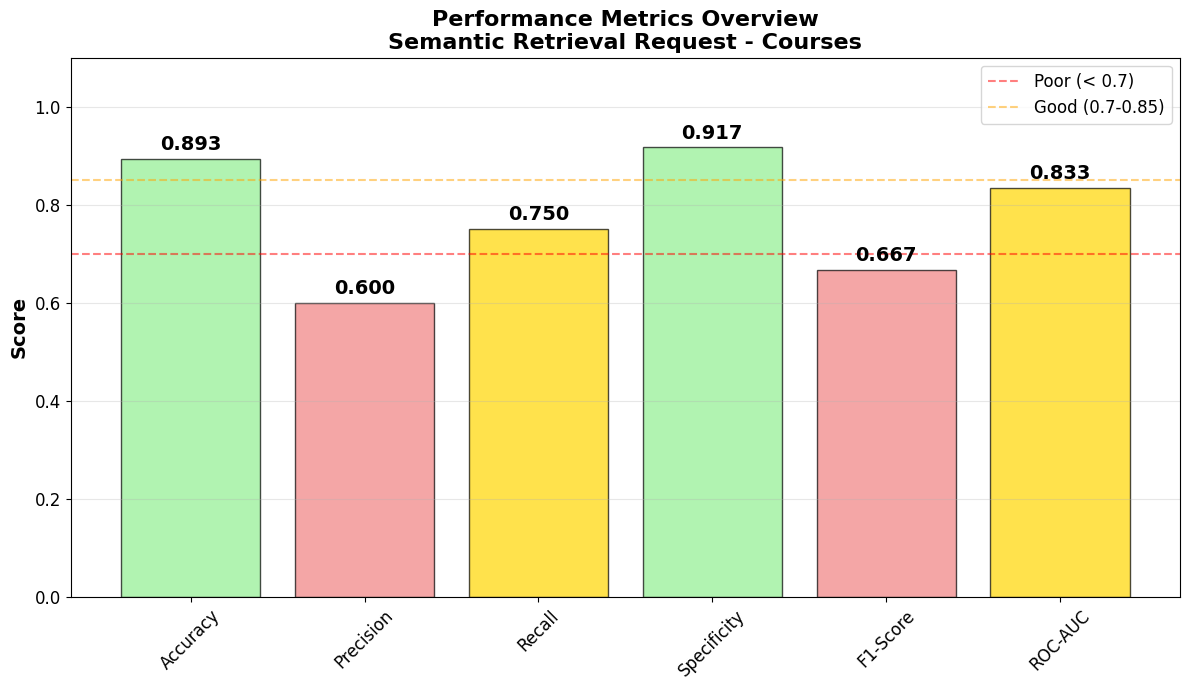

{'confusion_matrix': {'tn': 44, 'fp': 4, 'fn': 2, 'tp': 6},
 'metrics': {'accuracy': 0.8928571428571429,
  'precision': 0.6,
  'recall': 0.75,
  'specificity': 0.9166666666666666,
  'f1': 0.6666666666666666,
  'roc_auc': 0.8333333333333333}}

In [8]:


# Evaluate the errors for semantic courses
y_true_courses = scenarios[scenarios['should_retrieve_semantic_courses'] != '?']['should_retrieve_semantic_courses'].map({'0': 0, '1': 1})
y_pred_courses = scenarios[scenarios['should_retrieve_semantic_courses'] != '?']['actually_requested_semantic_courses']

calculate_metrics(y_true_courses, y_pred_courses, 'Semantic Retrieval Request - Courses')

=== Semantic Retrieval Request - Programs ===

Confusion Matrix Components:
              Metric  Count
 True Positives (TP)      5
False Positives (FP)      1
 True Negatives (TN)     45
False Negatives (FN)      5

Performance Metrics:
              Metric  Value                             Formula/Description
            Accuracy 0.8929                 (TP + TN) / (TP + TN + FP + FN)
           Precision 0.8333                                  TP / (TP + FP)
Recall (Sensitivity) 0.5000                                  TP / (TP + FN)
         Specificity 0.9783                                  TN / (TN + FP)
            F1-Score 0.6250 2 * (Precision * Recall) / (Precision + Recall)
             ROC-AUC 0.7391                            Area Under ROC Curve

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        46
           1       0.83      0.50      0.62        10

    accuracy                     

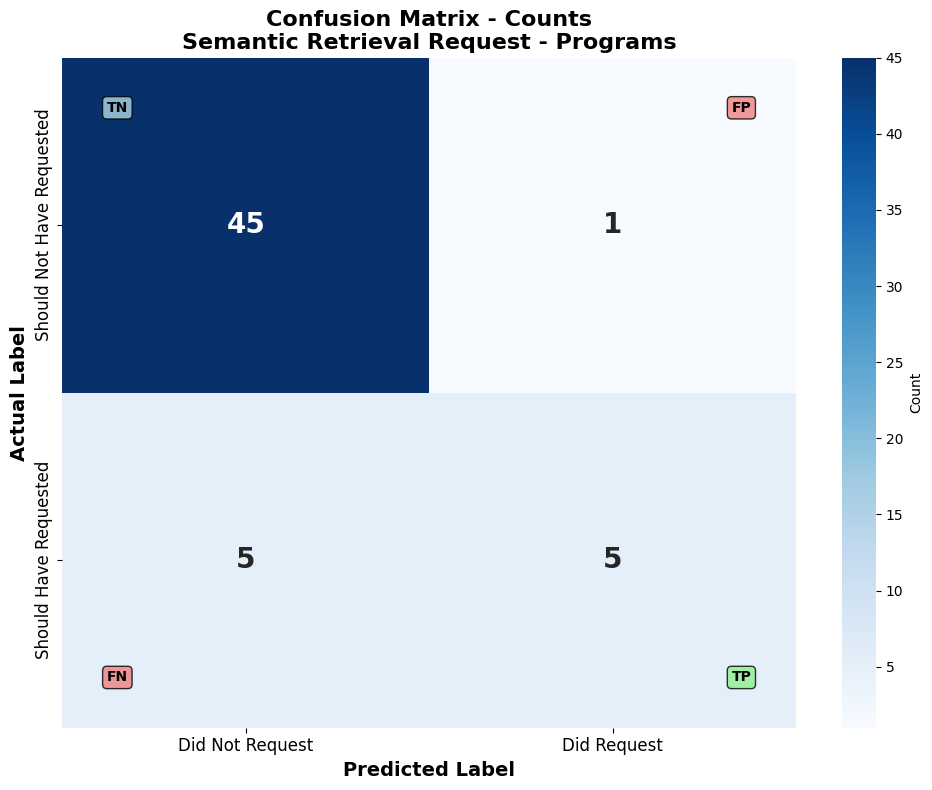

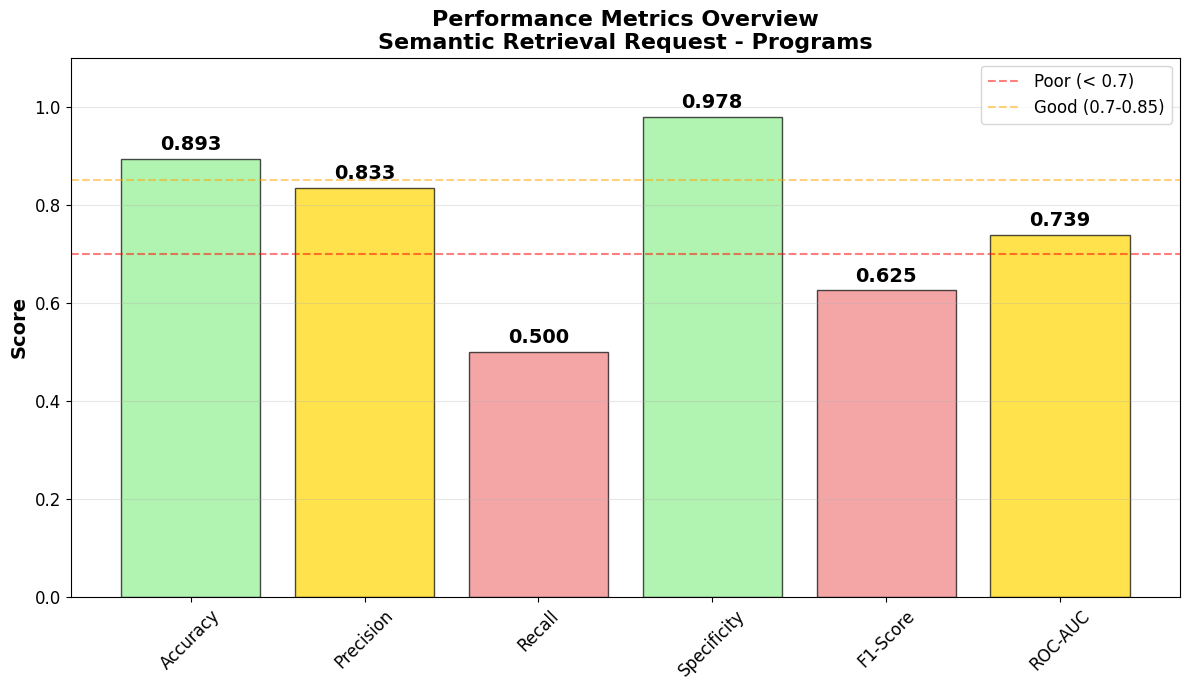

{'confusion_matrix': {'tn': 45, 'fp': 1, 'fn': 5, 'tp': 5},
 'metrics': {'accuracy': 0.8928571428571429,
  'precision': 0.8333333333333334,
  'recall': 0.5,
  'specificity': 0.9782608695652174,
  'f1': 0.625,
  'roc_auc': 0.7391304347826088}}

In [52]:
# Evaluate errors for semantic programs
y_true_programs = scenarios[scenarios['should_retrieve_semantic_programs'] != '?']['should_retrieve_semantic_programs'].map({'0': 0, '1': 1})
y_pred_programs = scenarios[scenarios['should_retrieve_semantic_programs'] != '?']['actually_requested_semantic_programs']
calculate_metrics(y_true_programs, y_pred_programs, 'Semantic Retrieval Request - Programs')

=== Semantic Retrieval Request - Resources ===

Confusion Matrix Components:
              Metric  Count
 True Positives (TP)     30
False Positives (FP)     15
 True Negatives (TN)      9
False Negatives (FN)      2

Performance Metrics:
              Metric  Value                             Formula/Description
            Accuracy 0.6964                 (TP + TN) / (TP + TN + FP + FN)
           Precision 0.6667                                  TP / (TP + FP)
Recall (Sensitivity) 0.9375                                  TP / (TP + FN)
         Specificity 0.3750                                  TN / (TN + FP)
            F1-Score 0.7792 2 * (Precision * Recall) / (Precision + Recall)
             ROC-AUC 0.6562                            Area Under ROC Curve

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.38      0.51        24
           1       0.67      0.94      0.78        32

    accuracy                    

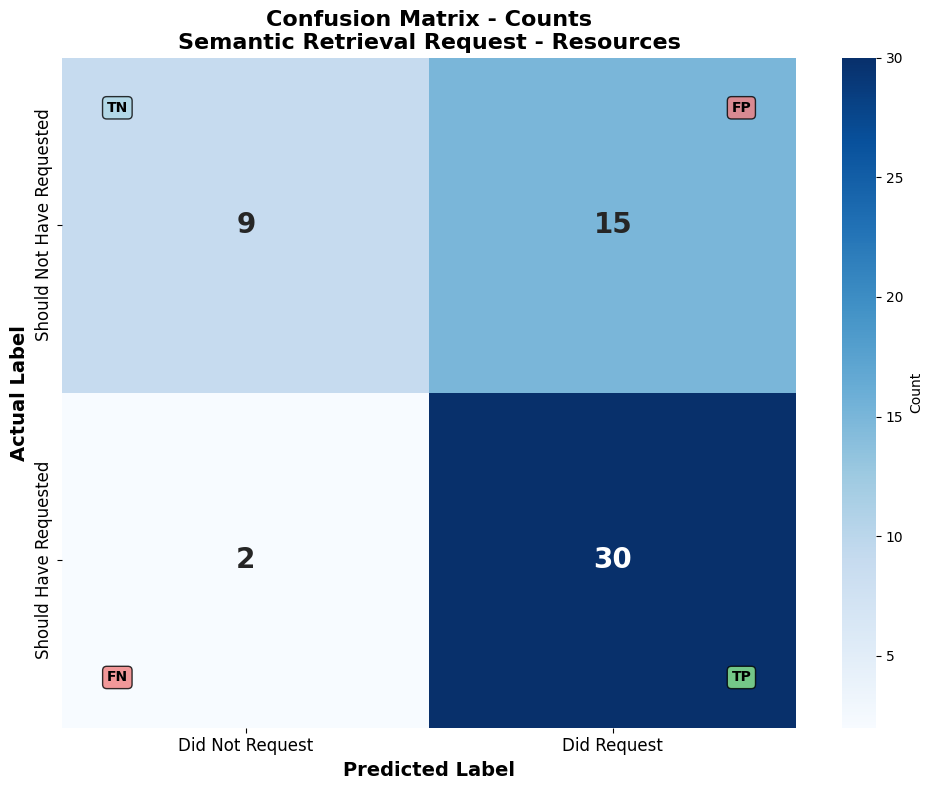

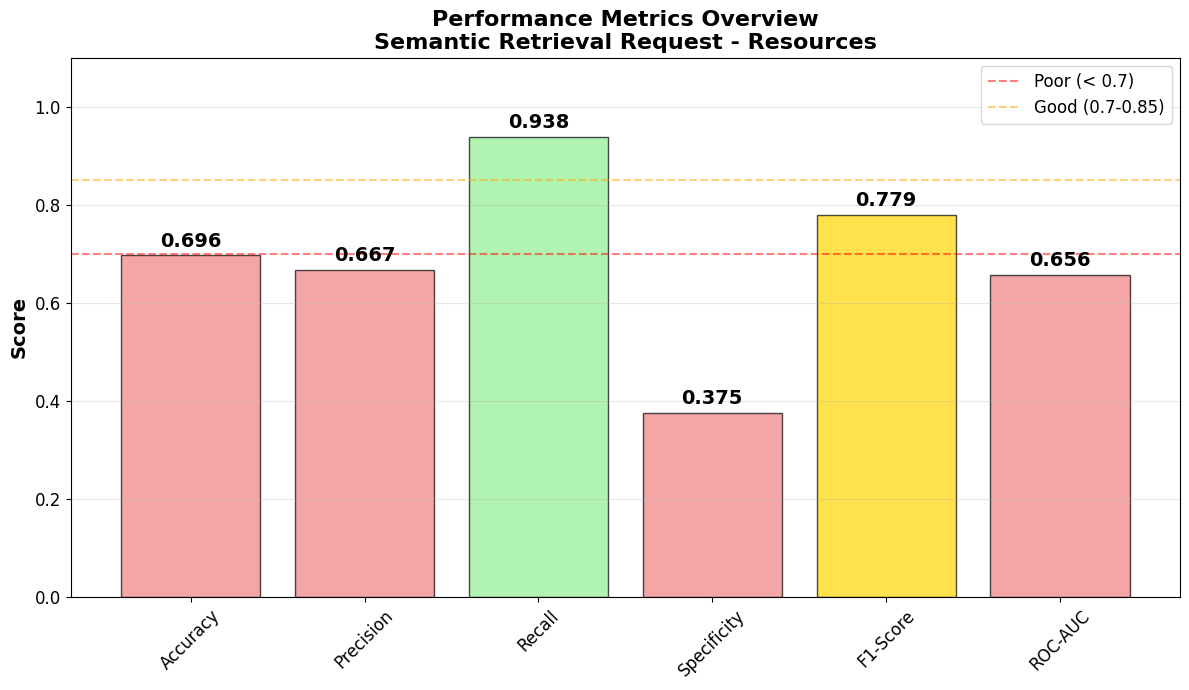

{'confusion_matrix': {'tn': 9, 'fp': 15, 'fn': 2, 'tp': 30},
 'metrics': {'accuracy': 0.6964285714285714,
  'precision': 0.6666666666666666,
  'recall': 0.9375,
  'specificity': 0.375,
  'f1': 0.7792207792207793,
  'roc_auc': 0.65625}}

In [53]:
# Evaluate the errors for semantic resources
y_true_resources = scenarios[scenarios['should_request_semantic_support_resources'] != '?']['should_request_semantic_support_resources'].map({'0': 0, '1': 1})
y_pred_resources = scenarios[scenarios['should_request_semantic_support_resources'] != '?']['actually_requested_semantic_support_resources']
calculate_metrics(y_true_resources, y_pred_resources, 'Semantic Retrieval Request - Resources')

=== Specific Retrieval Request - Current Major ===

Confusion Matrix Components:
              Metric  Count
 True Positives (TP)     14
False Positives (FP)      3
 True Negatives (TN)     24
False Negatives (FN)      7

Performance Metrics:
              Metric  Value                             Formula/Description
            Accuracy 0.7917                 (TP + TN) / (TP + TN + FP + FN)
           Precision 0.8235                                  TP / (TP + FP)
Recall (Sensitivity) 0.6667                                  TP / (TP + FN)
         Specificity 0.8889                                  TN / (TN + FP)
            F1-Score 0.7368 2 * (Precision * Recall) / (Precision + Recall)
             ROC-AUC 0.7778                            Area Under ROC Curve

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        27
           1       0.82      0.67      0.74        21

    accuracy                

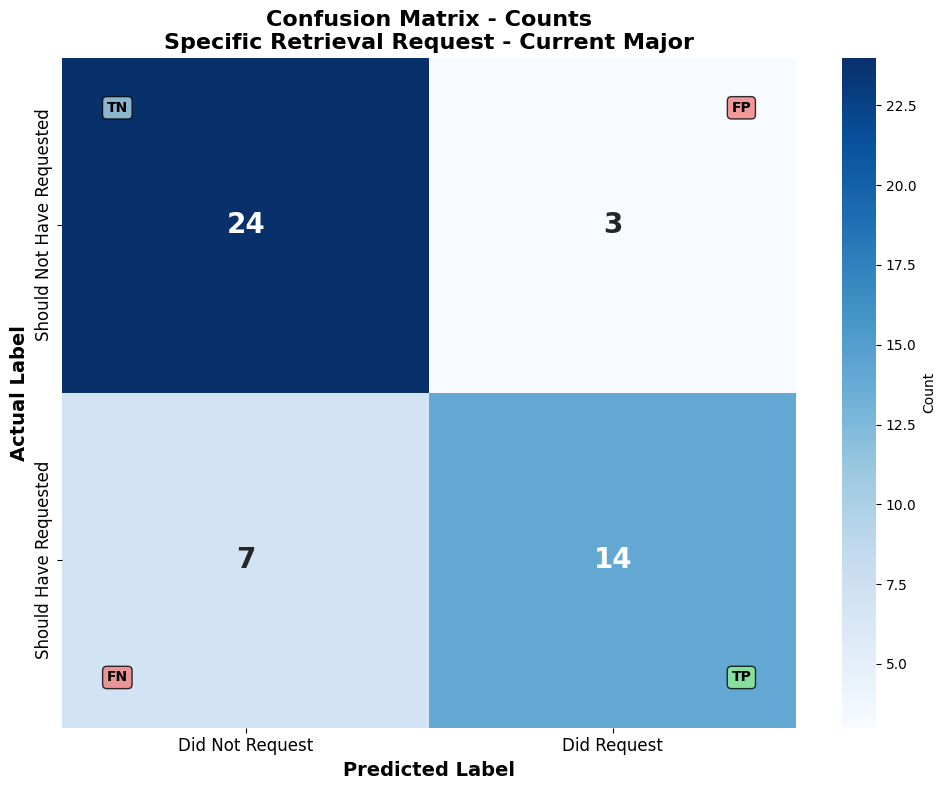

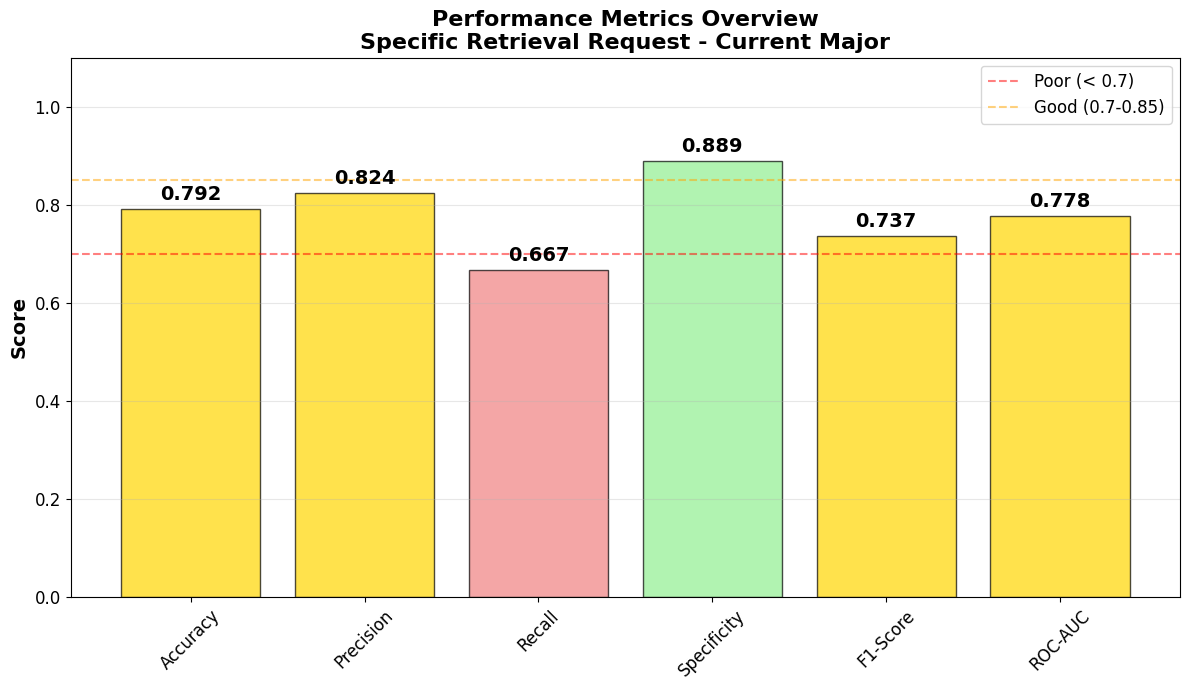

{'confusion_matrix': {'tn': 24, 'fp': 3, 'fn': 7, 'tp': 14},
 'metrics': {'accuracy': 0.7916666666666666,
  'precision': 0.8235294117647058,
  'recall': 0.6666666666666666,
  'specificity': 0.8888888888888888,
  'f1': 0.7368421052631579,
  'roc_auc': 0.7777777777777777}}

In [54]:
# Evaluate the errors for major information
y_true_current_major = scenarios[scenarios['should_retrieve_current_major'] != '?']['should_retrieve_current_major'].map({'0': 0, '1': 1})
y_pred_current_major = scenarios[scenarios['should_retrieve_current_major'] != '?']['actually_requested_current_major']
calculate_metrics(y_true_current_major, y_pred_current_major, 'Specific Retrieval Request - Current Major')

=== Specific Retrieval Request - Current Major Sample Schedules ===

Confusion Matrix Components:
              Metric  Count
 True Positives (TP)     11
False Positives (FP)      0
 True Negatives (TN)     36
False Negatives (FN)      2

Performance Metrics:
              Metric  Value                             Formula/Description
            Accuracy 0.9592                 (TP + TN) / (TP + TN + FP + FN)
           Precision 1.0000                                  TP / (TP + FP)
Recall (Sensitivity) 0.8462                                  TP / (TP + FN)
         Specificity 1.0000                                  TN / (TN + FP)
            F1-Score 0.9167 2 * (Precision * Recall) / (Precision + Recall)
             ROC-AUC 0.9231                            Area Under ROC Curve

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        36
           1       1.00      0.85      0.92        13

    accurac

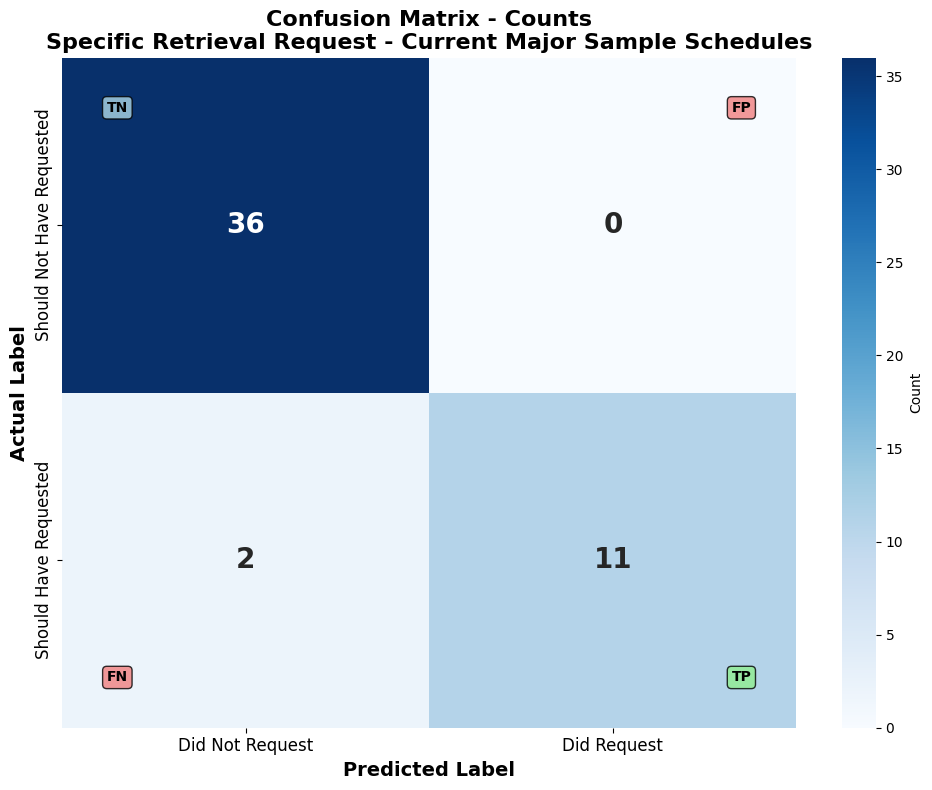

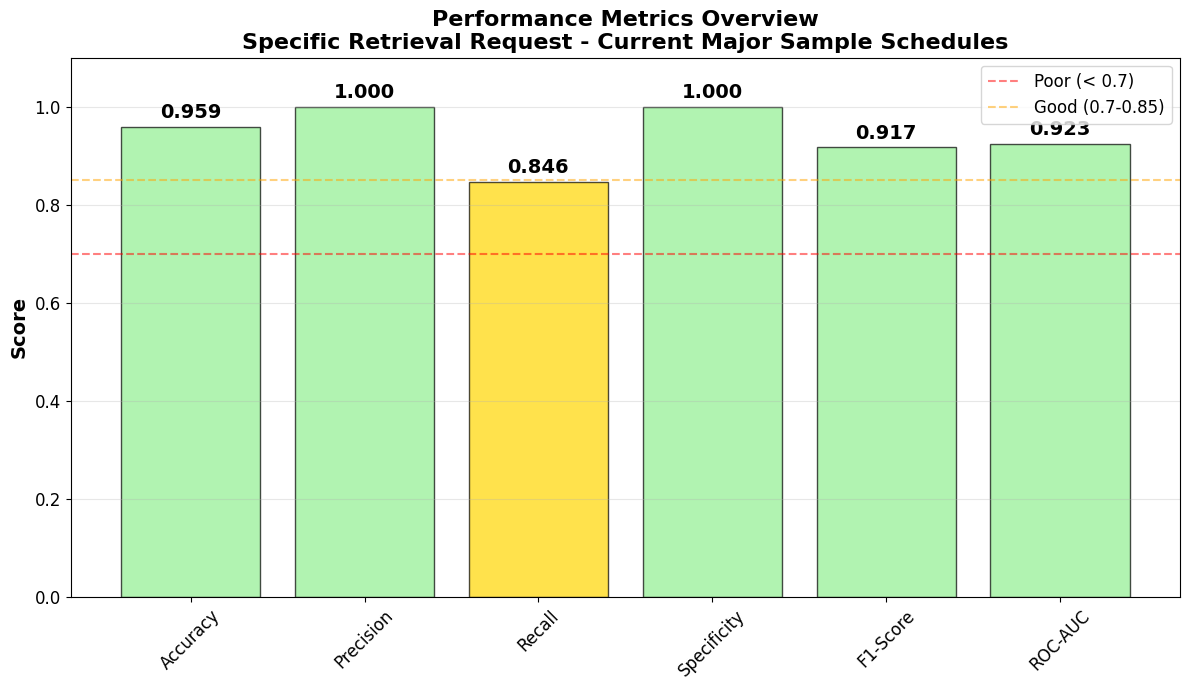

{'confusion_matrix': {'tn': 36, 'fp': 0, 'fn': 2, 'tp': 11},
 'metrics': {'accuracy': 0.9591836734693877,
  'precision': 1.0,
  'recall': 0.8461538461538461,
  'specificity': 1.0,
  'f1': 0.9166666666666666,
  'roc_auc': 0.9230769230769231}}

In [55]:
# Evaluate the errors for major sample schedules
y_true_current_major_sample_schedules = scenarios[scenarios['should_retrieve_current_major_sample_schedule'] != '?']['should_retrieve_current_major_sample_schedule'].map({'0': 0, '1': 1})
y_pred_current_major_sample_schedules = scenarios[scenarios['should_retrieve_current_major_sample_schedule'] != '?']['actually_requested_current_major_sample_schedules']
calculate_metrics(y_true_current_major_sample_schedules, y_pred_current_major_sample_schedules, 'Specific Retrieval Request - Current Major Sample Schedules')

In [ ]:
# Evaluate all errors together
